In [51]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.annotation.ggs import GreedyGaussianSegmentation
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import os

def load_data(data_dir='../data/raw', columns_to_load=None, date_parse_columns=['date']):
    """
    Load all CSV files from the specified directory and returns a list of dataframes
    ---
    Returns:
        dataframes: a list of dataframes; each dataframe is a patient's data loaded from the csv files
    """
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(os.path.join(data_dir, file), usecols=columns_to_load, parse_dates=date_parse_columns)
        # df['patient_id'] = file.split('_')[0]  # Extract patient ID from filename
        dataframes.append(df)
    
    # combined_df = pd.concat(dataframes, ignore_index=True, axis=0)
    # combined_df = dataframes[0]
    print(f"Loaded data from {len(csv_files)} files.")
    return dataframes

def preprocess_data(df):
    """
    Preprocess the combined DataFrame.
    ---
    1. Fill NaN values with 0
    2. Replace 0 with 'NULL' in the 'msg_type' column
    3. One hot encode the 'msg_type' column
    4. Drop irrelevant columns for the target variable 
    (in this case, only keeps 'ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN')
    5. Drop rows with invalid dates
    6. Change affects_fob and affects_iob to 1 and 0
    """
    df = df.fillna(0)
    df['msg_type'] = df['msg_type'].replace(0, 'NULL')

    # Convert 'date' column to datetime with a custom format
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    
    # Drop rows where the date is null or invalid
    df = df.dropna(subset=['date'])
    
    # Sort by date and handle duplicate timestamps
    df = df.sort_values('date')
    
    # Set 'date' as the index
    df.set_index('date', inplace=True)
    # Change affects_fob and affects_iob to 1 and 0
    df['affects_fob'] = df['affects_fob'].apply(lambda x: 1 if x != 0 else 0)
    df['affects_iob'] = df['affects_iob'].apply(lambda x: 1 if x != 0 else 0)

    RELEVANT_MSG_TYPES = ['ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN']
    
    encoder = OneHotEncoder(categories='auto', sparse_output=False)
    encoded_data = encoder.fit_transform(df[['msg_type']])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['msg_type']), index=df.index)
    
    df = df.drop(columns=['msg_type'])
    df = pd.concat([df, encoded_df], axis=1)
    
    COLUMNS_TO_DROP = [col for col in df.columns if 'msg_type' in col and not any(msg_type in col for msg_type in RELEVANT_MSG_TYPES)]
    df.drop(columns=COLUMNS_TO_DROP, inplace=True)
    
    return df


In [52]:
def greedy_gaussian_segmentation(df, supervised=False, label_column=None, timeframe_days=None, k_max=10, time_column='day_4am', specific_days=None):
    """
    Perform greedy Gaussian segmentation on the DataFrame using sktime's GreedyGaussianSegmentation.
    ---
    df: a dataframe; each row is a timestamp and each column is a feature
    supervised: boolean, whether to use supervised learning
    label_column: string, name of the column containing labels for supervised learning
    timeframe_days: int, number of days to segment (if None and specific_days is None, use all data)
    k_max: int, maximum number of segments to consider
    time_column: string, name of the column containing timestamps
    specific_days: list of datetime.date objects, if provided, apply segmentation on these specific days
    ---
    Returns:
        segmentation: of shape (n_samples, ) where n_samples is the number of samples in X_nested
        each entry in segmentation is an integer indicating the segment number
        X_nested: the time series data
    """
    # Filter data based on specific_days if provided, otherwise use timeframe_days
    if specific_days is not None:
        print("Using specific days for segmentation...")
        if time_column in df.columns:
            df = df[df[time_column].dt.date.isin(specific_days)]
        else:
            df = df[df.index.date.isin(specific_days)]
    elif timeframe_days is not None:
        print(f"Selecting {timeframe_days} adjacent days for segmentation...")
        if time_column in df.columns:
            unique_days = pd.to_datetime(df[time_column]).dt.floor('D').unique()
            start_day = np.random.choice(unique_days[:-timeframe_days])
            end_day = start_day + pd.Timedelta(days=timeframe_days)
            df = df[(df[time_column] >= start_day) & (df[time_column] < end_day)]
        else: # For the case where the index is a datetime index
            unique_days = pd.to_datetime(df.index).floor('D').unique()
            start_day = np.random.choice(unique_days[:-timeframe_days])
            end_day = start_day + pd.Timedelta(days=timeframe_days)
            df = df[(df.index >= start_day) & (df.index < end_day)]

    else:
        print("Using all available data for segmentation...")

    # Separate X and y
    if supervised and label_column:
        print("Preparing data for supervised learning...")
        X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col or col == label_column or col == time_column])
        y = df[label_column]
    else:
        print("Preparing data for unsupervised learning...")
        X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col])
        y = None

    # Ensure X is not empty
    if X.empty:
        raise ValueError("X is empty after dropping columns. Check your column names and filtering.")

    # Convert X to the required format for sktime
    X_nested = X.copy()

    # Initialize and fit the segmentation model
    segmenter = GreedyGaussianSegmentation(k_max=k_max, verbose=True)
    
    # Fit the model
    print("Beginning to fit the GGS Model...")
    try:
        if supervised and y is not None:
            print("Starting supervised training...")
            segmenter.fit(X_nested, y)
        else:
            segmenter.fit(X_nested)
        segmentation = segmenter.predict(X_nested)
    except Exception as e:
        print(f"Error during fitting: {e}")
        print(f"X_nested shape: {X_nested.shape}")
        print(f"X_nested dtypes: {X_nested.dtypes}")
        raise

    return segmentation, X_nested


In [53]:
def visualize_segmentation(X_nested, segmentation, column_name='bgl'):
    '''
    Visualize the segmented time series data
    ---
    X_nested: the time series data
    segmentation: of shape (n_samples, ) where n_samples is the number of samples in X_nested
        each entry in segmentation is an integer indicating the segment number
    column_name: the name of the column to plot
    '''
    plt.figure(figsize=(15, 8))
    
    # plot the time series
    plt.plot(X_nested.index, X_nested[column_name].values.flatten(), label=column_name)
    
    # plot segmentation
    unique_segments = np.unique(segmentation)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))
    
    for segment, color in zip(unique_segments, colors):
        mask = segmentation == segment
        plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                    alpha=0.2, color=color, label=f'Segment {segment}')
    
    plt.title(f'{column_name} Over Time with Segmentation')
    plt.xlabel('Time')
    plt.ylabel(column_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# segmentation.shape
# visualize_segmentation(X_nested, segmentation)

# Version 1: Unsupervised
The version below is unsupervised. That is, it is not trained to segment the data in a particular way.
The meal annotation plus 2 hours dataset is NOT used. The standard GGS algorithm is applied to the entire dataset (individually to each patient's data)


Loaded data from 2 files.
Selecting 17 adjacent days for segmentation...
Preparing data for unsupervised learning...
Beginning to fit the GGS Model...


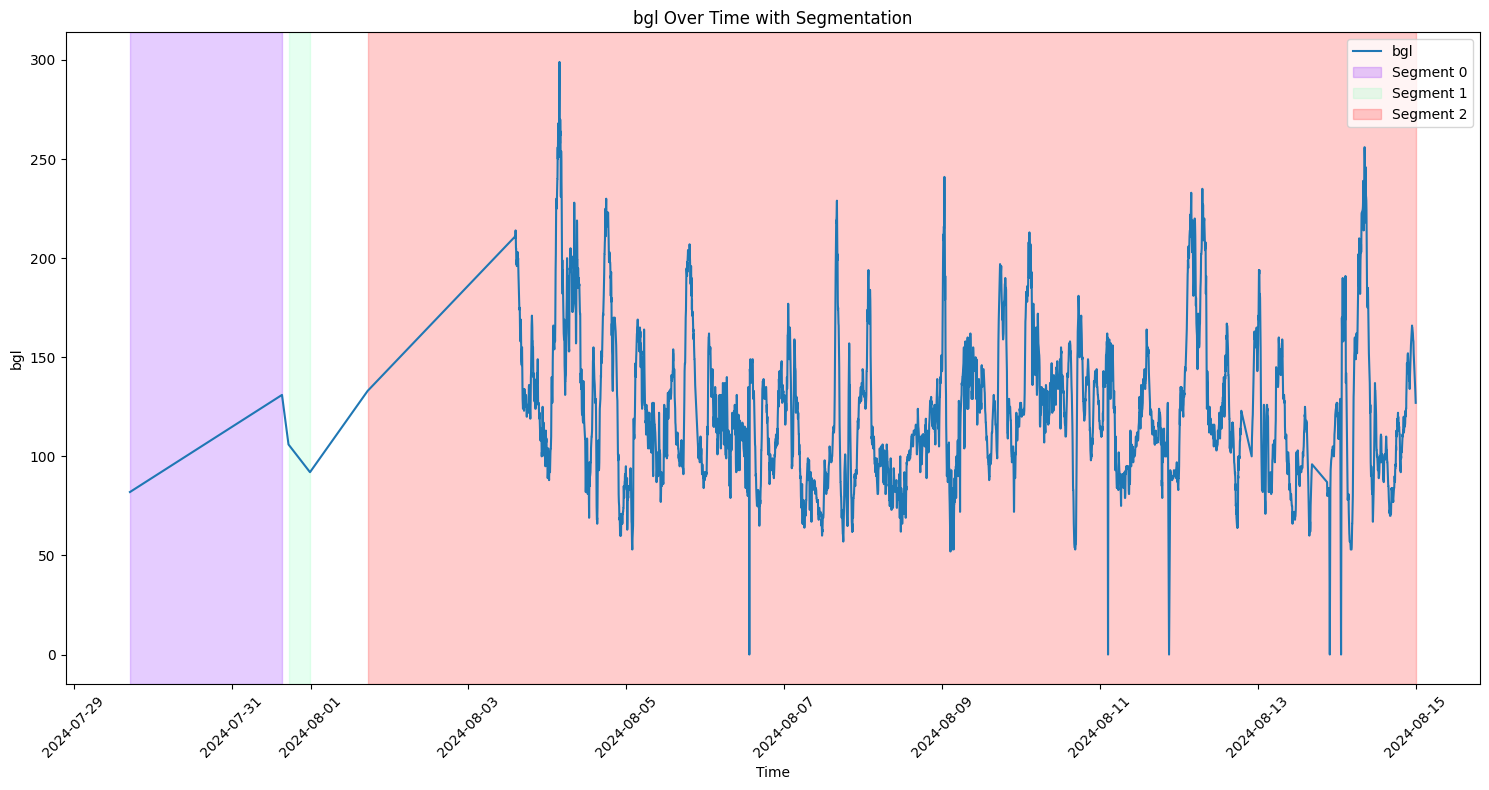

Selecting 17 adjacent days for segmentation...
Preparing data for unsupervised learning...
Beginning to fit the GGS Model...


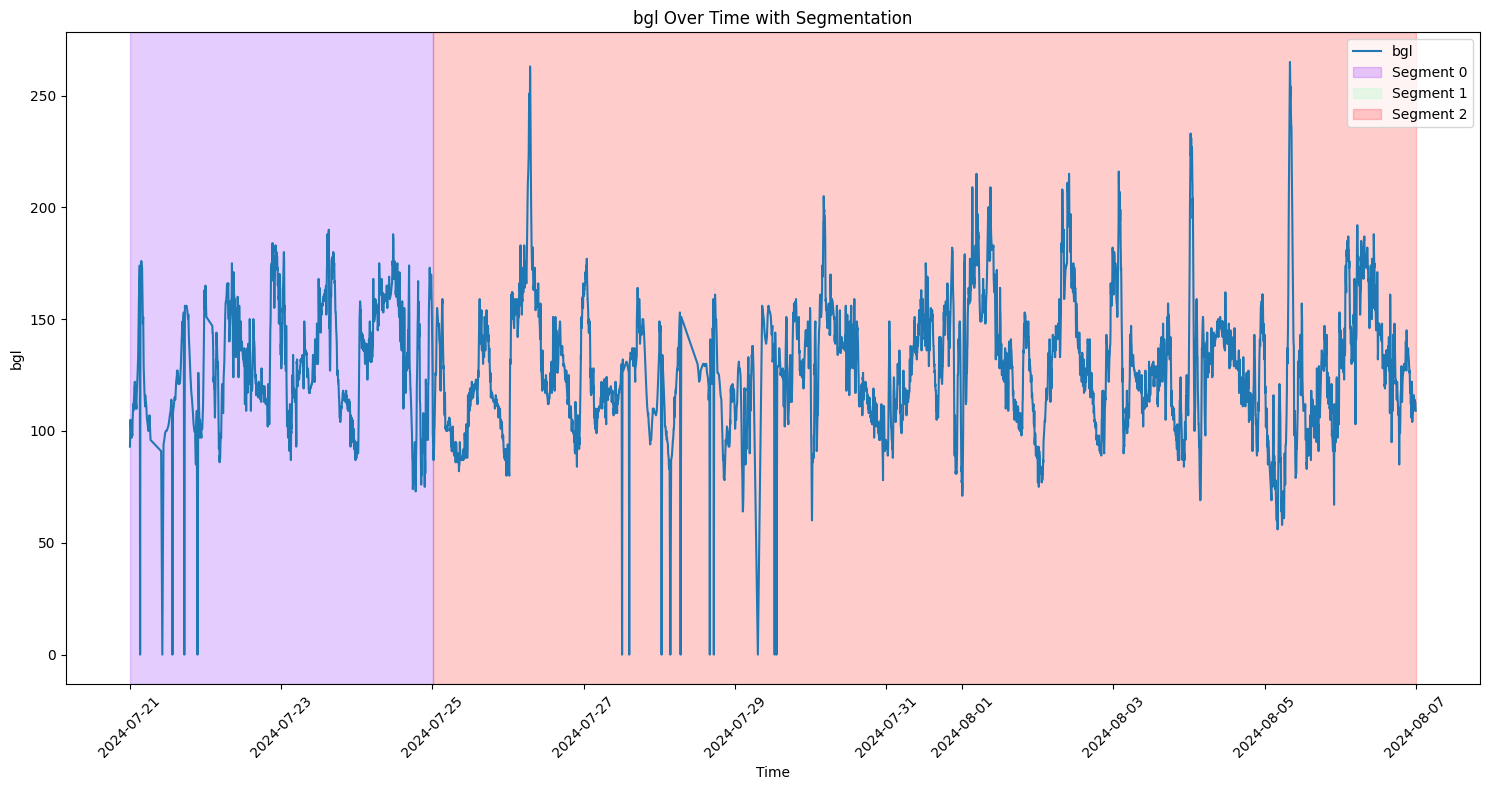

In [54]:
dataframes = load_data(columns_to_load = ['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob', 'dose_units', 'food_g', 'food_glycemic_index'])
for df in dataframes:
    df = preprocess_data(df)
    segmentation, X_nested = greedy_gaussian_segmentation(df, supervised=False, timeframe_days=17, k_max=10, time_column='date')
    visualize_segmentation(X_nested, segmentation)

# ** Second visualization only has one segment. Perhaps because there is no ANNOUNCE_MEAL?

# Version 2: Supervised
This version is supervised. That is, it is trained to segment the data in a particular way.
The meal annotation plus 2 hours dataset is used. The standard GGS algorithm is applied to the entire dataset (individually to each patient's data)
The goal of this model is to segment the data around meal times.


In [55]:
df = pd.read_csv("../data/interim/meal_annotation_plus_2hr_meal.csv", parse_dates=['day_4am'])

# Sort by day_4am, then reset index to use row number as timestep
df = df.sort_values('day_4am').reset_index(drop=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Handle NaN values
df['bgl'] = df['bgl'].fillna(method='ffill')  # Forward fill for blood glucose levels
df['dose_units'] = df['dose_units'].fillna(0)  # Fill NaN dose units with 0
df['food_g'] = df['food_g'].fillna(0)  # Fill NaN food grams with 0

def create_meal_labels(df):
    """
    Taken from notebook 1.02
    """
    labels = np.zeros(len(df))
    meal_start = df['msg_type'] == 'ANNOUNCE_MEAL'
    meal_end = df['msg_type'] == 'MEAL_END'
    
    meal_counter = 1
    active_meals = []
    
    for i in range(len(df)):
        if meal_start.iloc[i]:
            active_meals.append(meal_counter)
            meal_counter += 1
        
        if len(active_meals) > 0:
            labels[i] = active_meals[-1]
        
        if meal_end.iloc[i] and len(active_meals) > 0:
            active_meals.pop()
    
    return labels

# Generate meal segment labels
meal_labels = create_meal_labels(df)

# Create a new column for the meal segment labels
df['meal_segment'] = meal_labels

supervised_segmentation, X_nested = greedy_gaussian_segmentation(df, supervised=True, label_column='meal_segment', timeframe_days=7, k_max=30)



C:\Users\viloh\AppData\Local\Temp\ipykernel_7056\2108837825.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['bgl'] = df['bgl'].fillna(method='ffill')  # Forward fill for blood glucose levels


Selecting 7 adjacent days for segmentation...
Preparing data for supervised learning...
Beginning to fit the GGS Model...
Starting supervised training...


### Visualize supervised results
Plots the results. 
1. The first graph shows what the model predicted for its segments
2. The second graph shows the actual segments in the data

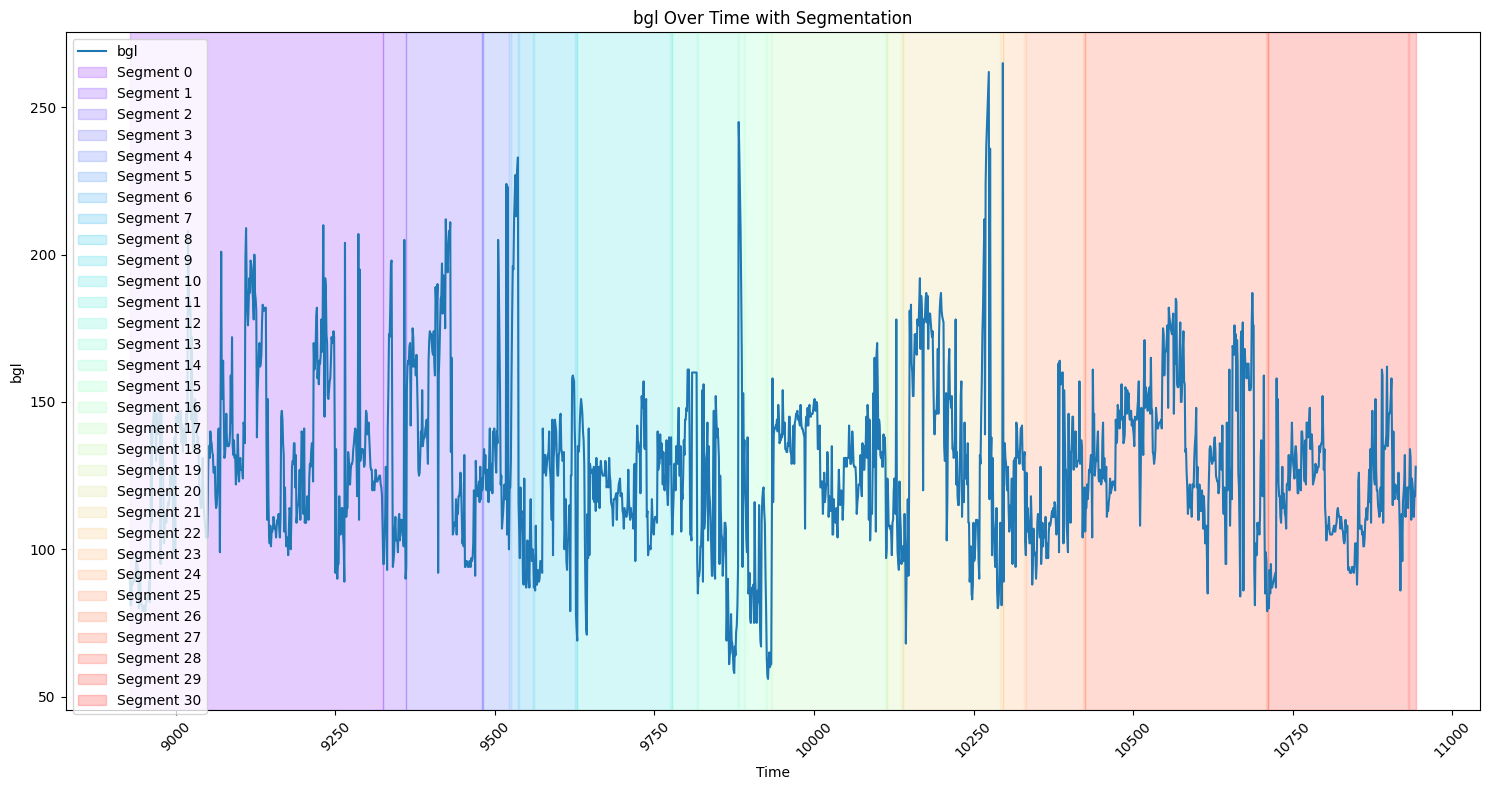

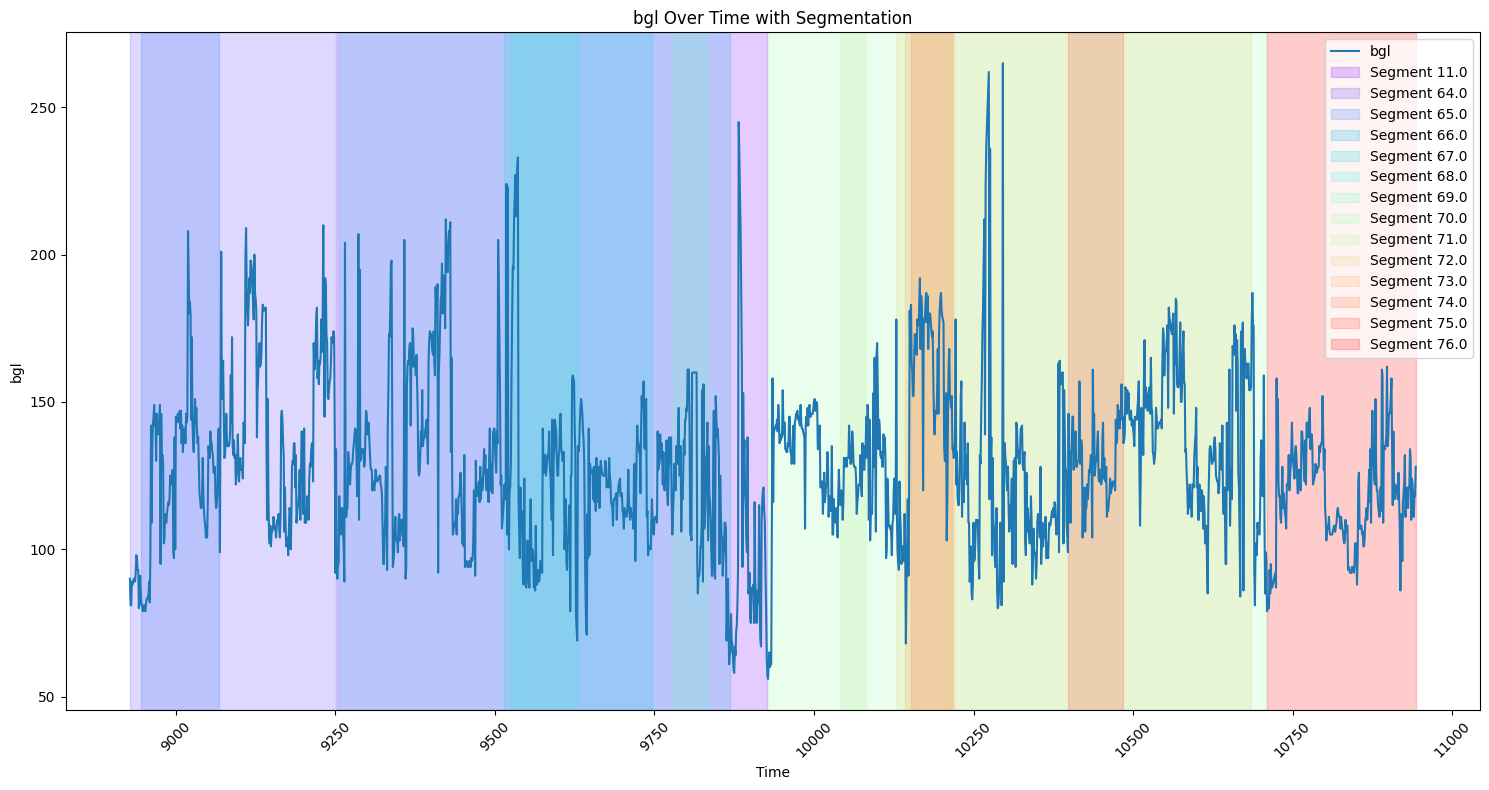

In [56]:
# Visualize the results
# Supervised GGS segmentation
visualize_segmentation(X_nested[['bgl']], supervised_segmentation, column_name='bgl')

# Labelled segmentation from the data
# Filter the meal_segment data based on the timeframe used for X_nested
start_date = X_nested.index[0]
end_date = X_nested.index[-1]
filtered_meal_segment = df.loc[start_date:end_date, 'meal_segment']

# Visualize the filtered meal segments
visualize_segmentation(X_nested[['bgl']], filtered_meal_segment, column_name='bgl')
